In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn = C_syn
        self.bias = bias
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1, bias=self.bias))
        
        
    def forward(self, S, temp, test):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        W_clust = self.C_syn
        
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        ####
        raw_out = torch.zeros(T_data, self.sub_no*self.H_no).to(self.device)
        ###
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
            
            ####
            raw_out[:,s*self.H_no:(s+1)*self.H_no] = raw_out[:,s*self.H_no:(s+1)*self.H_no] + rnn_out.squeeze(0)
            #####
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out, W_clust
        #return final, raw_out, W_clust

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
device = "cuda"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)


In [4]:
V_test = V[-50000:].to(device).float()
test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)


In [5]:
H_no = 4
layer_no = 1
sub_no = 4
in_no = 299
T_no = 501
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
temp = 0
bias = False

In [6]:

C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt"))
model.eval()
model.cuda()

GenericGRU(
  (rnn): ModuleList(
    (0): GRU(1, 4, batch_first=True)
    (1): GRU(1, 4, batch_first=True)
    (2): GRU(1, 4, batch_first=True)
    (3): GRU(1, 4, batch_first=True)
  )
  (linear): ModuleList(
    (0): Linear(in_features=4, out_features=1, bias=False)
    (1): Linear(in_features=4, out_features=1, bias=False)
    (2): Linear(in_features=4, out_features=1, bias=False)
    (3): Linear(in_features=4, out_features=1, bias=False)
  )
)

In [8]:
repeat_no = 200

full_out = np.zeros((repeat_no,4,50000))

for i in tnrange(repeat_no):
    in_neural = E_neural[i*50000:(i+1)*50000].toarray()
    in_neural = torch.from_numpy(in_neural).float().to(device)
    
    V_pred, sub_out, W_clust = model(in_neural[:,e_idx], 0, True)
    full_out[i] = sub_out.cpu().detach().numpy().T

<ipython-input-8-80fcf5c104b8>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(repeat_no):


In [9]:
np.save("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat_subout.npy", full_out)

In [11]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt"))
model.eval()
model.cuda()

GenericGRU(
  (rnn): ModuleList(
    (0): GRU(1, 4, batch_first=True)
    (1): GRU(1, 4, batch_first=True)
    (2): GRU(1, 4, batch_first=True)
    (3): GRU(1, 4, batch_first=True)
  )
  (linear): ModuleList(
    (0): Linear(in_features=4, out_features=1, bias=False)
    (1): Linear(in_features=4, out_features=1, bias=False)
    (2): Linear(in_features=4, out_features=1, bias=False)
    (3): Linear(in_features=4, out_features=1, bias=False)
  )
)

In [12]:
test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)

In [13]:
sub_neural = torch.matmul(test_E_neural[:,e_idx],C_syn.T)
sub_neural = sub_neural.cpu().detach().numpy()
print(sub_neural.shape)

(50000, 4)


Text(0.5, 0.9, 'Subunit 3, H=4')

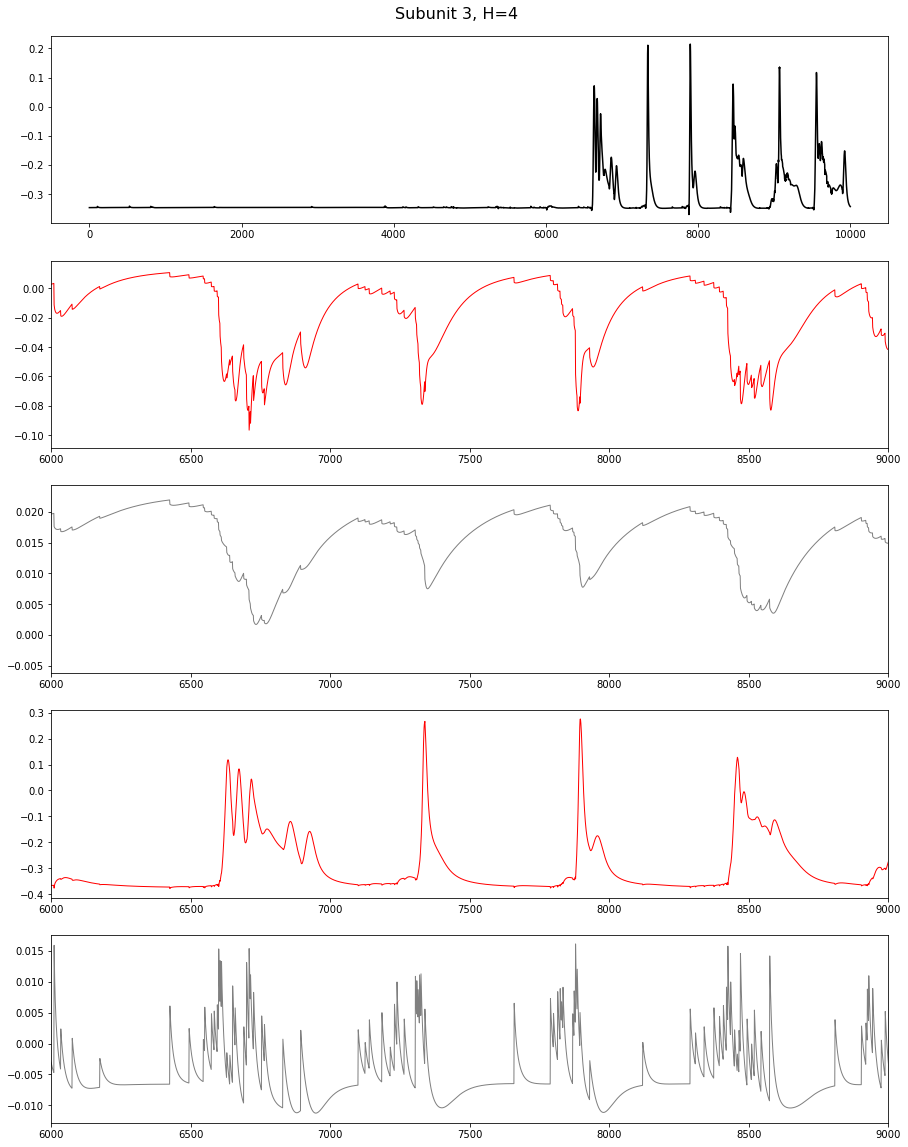

In [40]:
fig, axs = plt.subplots(nrows=H_no+1, figsize = (15,20))

sub = 3

W = model.linear[sub].weight.cpu().detach().numpy().flatten()

total = np.zeros((10000))

min_val = np.min(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)
max_val = np.max(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)

for i in range(H_no):
    mean = np.mean(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #min_val = np.min(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #max_val = np.max(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    
    if W[i] >= 0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="red", linewidth=1)
    elif W[i] <= -0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="blue", linewidth=1)
    else:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="gray", linewidth=1)
    
    #axs[i+1].scatter(np.arange(10000), sub_neural[16000:26000,sub]-1+mean, marker="|", s=250, color="orange", linewidth=1)
    #axs[i+1].set_ylim(min_val, max_val)
    axs[i+1].set_xlim(6000,9000)
    total += test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i]
    
#axs[0].plot(V_test.cpu().detach().numpy()[16000:26000], color="black")
#axs[0].plot(test_V_pred.cpu().detach().numpy()[16000:26000], color="red")
axs[0].plot(total, color="black")
    
fig.suptitle("Subunit "+str(sub)+", H=" +str(H_no), y=0.9, fontsize = 16)
#plt.savefig("/media/hdd01/sklee/CA1_clust4-60/gru_s"+str(sub_no)+"_h"+str(H_no)+"_output_"+str(sub)+".png", dpi=150, bbox_inches='tight')

Text(0.5, 0.9, 'Subunit 3, H=4')

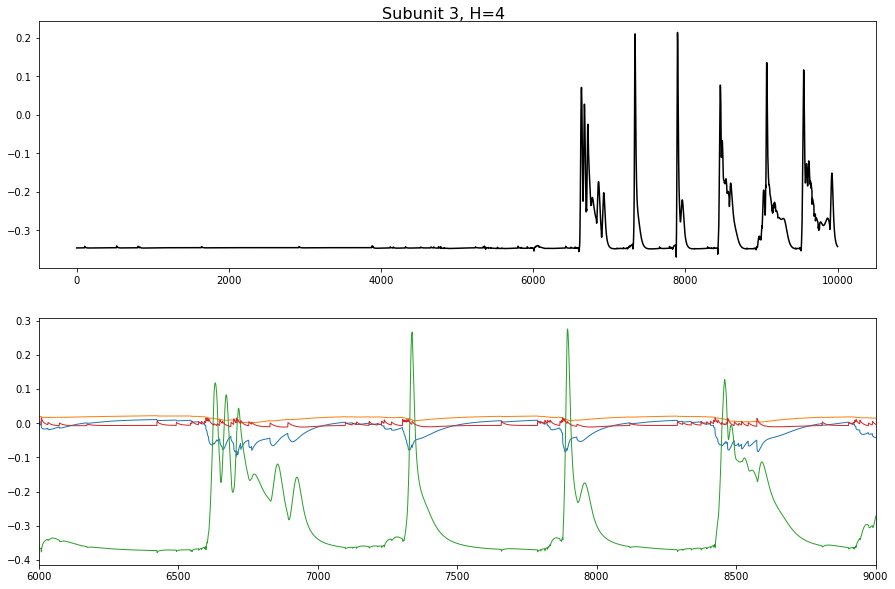

In [39]:
fig, axs = plt.subplots(nrows=2, figsize = (15,10))

sub = 3

W = model.linear[sub].weight.cpu().detach().numpy().flatten()

total = np.zeros((10000))

#min_val = np.min(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)
#max_val = np.max(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)

for i in range(H_no):
    mean = np.mean(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])

    axs[1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], linewidth=1)
    
    axs[1].set_xlim(6000,9000)
    total += test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i]
    

axs[0].plot(total, color="black")
    
fig.suptitle("Subunit "+str(sub)+", H=" +str(H_no), y=0.9, fontsize = 16)
#plt.savefig("/media/hdd01/sklee/CA1_clust4-60/gru_s"+str(sub_no)+"_h"+str(H_no)+"_output_"+str(sub)+".png", dpi=150, bbox_inches='tight')

In [42]:
#np.save("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat_subout.npy", test_sub_out.cpu().detach().numpy())